# Interactive Dust Maps from Lallement et al. (2019)
[ADS Reference](https://ui.adsabs.harvard.edu/abs/2019A%26A...625A.135L/abstract)

* **Import Packages**

In [1]:
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Interactive slider plot
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Interactive volume slide plot
import plotly.express as px
import plotly.graph_objects as go

* **Load the data "interactive_dust_cube.csv"**

In [2]:
dust = pd.read_csv('dust_25pc_resolution.csv', 
                   skipinitialspace = True, 
                   sep = ',',
                   comment='#', 
                   header =[0]
                  )

print('The data contains ' + str(len(dust)) + ' rows')
print('The columns in the data:')
print(dust.columns + '\n')
dust

The data contains 1916673 rows
The columns in the data:
Index(['X\n', 'Y\n', 'Z\n', 'Ext_avg\n'], dtype='object')


,X,Y,Z,Ext_avg
0,-3000.0,-3000.0,-400.0,0.000039
1,-3000.0,-3000.0,-375.0,0.000039
2,-3000.0,-3000.0,-350.0,0.000039
3,-3000.0,-3000.0,-325.0,0.000039
4,-3000.0,-3000.0,-300.0,0.000041
...,...,...,...,...
1916668,3000.0,3000.0,300.0,0.000316
1916669,3000.0,3000.0,325.0,0.000184
1916670,3000.0,3000.0,350.0,0.000116
1916671,3000.0,3000.0,375.0,0.000097


In [3]:
dust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1916673 entries, 0 to 1916672
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   X        float64
 1   Y        float64
 2   Z        float64
 3   Ext_avg  float64
dtypes: float64(4)
memory usage: 58.5 MB


* **Minimize memory usage**

In [4]:
dust['X'] = dust['X'].astype('int16')
dust['Y'] = dust['Y'].astype('int16')
dust['Z'] = dust['Z'].astype('int16')
dust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1916673 entries, 0 to 1916672
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   X        int16  
 1   Y        int16  
 2   Z        int16  
 3   Ext_avg  float64
dtypes: float64(1), int16(3)
memory usage: 25.6 MB


* **Define Color Blind Friendly Palette**

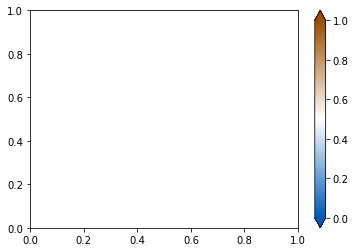

In [5]:
# Define two main colors for the diverging palette
main_colors = [(0/255, 90/255, 181/255), (153/255, 79/255, 0/255)] # normalized rgb

# Generate shades of the two main colors for the diverging palette
n_shades = 100

colors1 = np.linspace(main_colors[0], 
                      [1, 1, 1],
                      n_shades
                      )

colors2 = np.linspace(main_colors[1], 
                      [1, 1, 1],
                      n_shades
                      )

colors2_reversed = colors2[::-1] # reverse color2 so that midpoint between the 2 colors is the same

colors = np.vstack( (colors1, 
                     colors2_reversed)
                  )

# Create the diverging palette using the ListedColormap class
diverging_palette = ListedColormap(colors)

# Plot a colorbar to show the diverging colorblind-friendly palette
plt.colorbar(plt.cm.ScalarMappable(cmap=diverging_palette), 
             extend = 'both'
             )
plt.show()

# **Plot interstellar dust density maps along specified height, $Z$**

In [6]:
def XYZ(df, Z):

  subset = df[(df['Z'] == Z)] # create a subset over each layer of height Z

  # Create XY grid - N x N matrix
  X, Y = np.meshgrid(np.unique(subset['X']), 
                     np.unique(subset['Y'])
                     )
  
  # List of extinction values
  ext = np.array(subset['Ext_avg'])
    
  # Reshape to N x N matrix
  ext = ext.reshape( (len(np.unique(subset['X'])),
                     len(np.unique(subset['X'])))
                   )
  
  return X,Y,ext

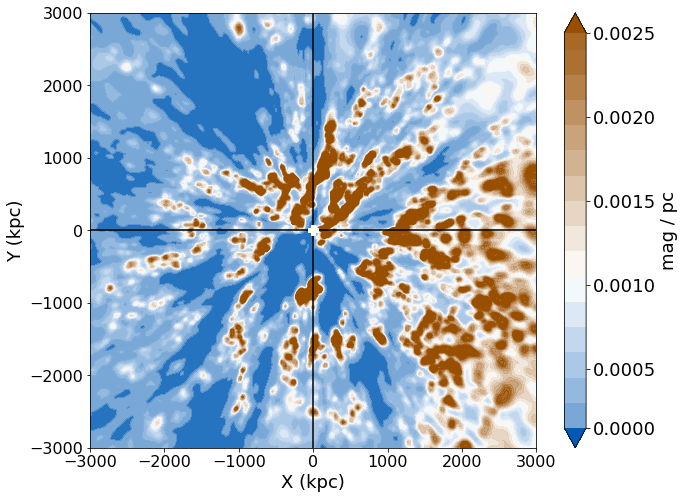

In [7]:
# Specify which vertical plane to plot, Z in parsec:
Z = 0

X,Y,ext = XYZ(dust, Z)

fgsize=(10,8.)
fig = plt.figure(figsize=fgsize)

ax = fig.gca()

# Plot dust map
cset1 = ax.contourf(X,
                    Y,
                    ext.T,
                    levels = 200,
                    vmin = -0.0003,
                    vmax = 0.0024,
                    cmap=diverging_palette,
                    extend = 'both',
                    alpha = 0.85,
                   )

# Define colorbar
cbar=plt.colorbar(mappable=cset1,
                  orientation="vertical", 
                  ticks = [0, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025]
                  )

cbar.set_label('mag / pc', fontsize=18)
cbar.ax.tick_params(labelsize=18) 
cbar.ax.set_ylim(0,0.0025)

ax.set_xlabel('X (kpc)', fontsize=18)
ax.set_ylabel('Y (kpc)', fontsize=18)

# Set XY limits
Xmin, Xmax = -3000, 3000
Ymin, Ymax = -3000, 3000
ax.set_xlim([Xmin,Xmax])
ax.set_ylim([Ymin,Ymax])
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

# Draw the axes.
plt.axhline(0,color='black')
plt.axvline(0,color='black')
# Draw the Sun at the origin
ax.plot([0,0],[0,0],marker='P',c='white',markersize=10) 

plt.show()

# **Slider**

In [8]:
def f(scale):
    
    # See comments in previous section

    X, Y, ext = XYZ(dust, scale) # run XYZ function from the previous section
    
    fgsize=(6.5,5.)
    fig = plt.figure(figsize=fgsize, dpi=150)

    ax = fig.gca()

    cset1 = ax.contourf(X,
                        Y,
                        ext.T,
                        levels = 200,
                        vmin = -0.0003,
                        vmax = 0.0024,
                        cmap=diverging_palette,
                        alpha = 0.85,
                        extend = 'both')

    cbar=plt.colorbar(mappable=cset1,
                      orientation="vertical", 
                      ticks = [0, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025]
                      )

    cbar.set_label('mag / pc', fontsize=18)
    cbar.ax.tick_params(labelsize=18) 
    cbar.ax.set_ylim(0,0.0020)

    ax.set_xlabel('X (kpc)', fontsize=18)
    ax.set_ylabel('Y (kpc)', fontsize=18)

    Xmin, Xmax = -3000, 3000
    Ymin, Ymax = -3000, 3000
    ax.set_xlim([Xmin,Xmax])
    ax.set_ylim([Ymin,Ymax])
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    
    # Draw the axes.
    plt.axhline(0,color='black')
    plt.axvline(0,color='black')
    # Draw the Sun at the origin
    ax.plot([0,0],[0,0],marker='P',c='white',markersize=10) 

    plt.show()

In [9]:
interactive_plot = interactive(f, # plot each plane
                               scale=widgets.IntSlider( # define slider
                                                      min=-300, # Z min
                                                      max=300, # Z max
                                                      step=25,
                                                      orientation='horizontal',
                                                      description='Z (pc)'
                                                      )
                              )

output = interactive_plot.children[-1]
output.layout.height = '750px'
interactive_plot

interactive(children=(IntSlider(value=0, description='Z (pc)', max=300, min=-300, step=25), Output(layout=Layo…

# **Volume Slices of Dust Map**

* **Configurate the Dust Map as a Volume**

In [10]:
def cube(df):
  z_values = np.unique(df['Z']) # find Z values for each layer
  subset = df[(df['Z'] == z_values[0])] # select first layer
  volume = subset['Ext_avg'] 
  counter = len(volume) # number of pixels is sqrt(counter)

  for i in z_values[1:]: # first layer is done
    subset = df.loc[(df['Z'] == i)].copy() # go over each other layer
    
    # Set volume cube
    volume = np.hstack( (volume, 
                        subset['Ext_avg']
                        )
                      )
    
  # Reshape to a M x N x N matrix
  volume = volume.reshape(len(z_values), 
                            int(np.sqrt(counter)), 
                            int(np.sqrt(counter)) 
                            )
  
  # Create XY grid - N x N matrix 
  x, y = np.meshgrid(np.unique(subset['X']),
                   np.unique(subset['Y'])
                   )
  
  return volume, x, y

In [11]:
volume, X, Y = cube(dust)
l, r, c = volume.shape
print(l, r, c)

33 241 241


* **Plot Dust Map in Volume slices**

In [ ]:
nb_frames = l # number of frames (layers)

fig = go.Figure(frames=[go.Frame(data=go.Surface(
    z=(25 * k) * np.ones((r, c)) - 400,
    surfacecolor=np.flipud(volume[k]), 
    colorscale='inferno_r',
    cmin=-0.0003, cmax=0.0024
    ),
    name=str(k) # you need to name the frame for the animation to behave properly
    )
    for k in range(nb_frames)] 
               )
    

# Add data to be displayed before animation starts
fig.add_trace(go.Surface(
    z= -400 * np.ones((r, c)),
    surfacecolor=np.flipud(volume[0]),
    colorscale='inferno_r',
    cmin=-0.0003, cmax=0.0024,
    colorbar=dict(thickness=20, ticklen=4)
    ))

def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]

# Layout
fig.update_layout(
         title='Slices in volumetric data',
         width=800,
         height=800, 
         scene=dict(
                    zaxis=dict(range=[-405, 405], autorange=False),
                    aspectratio=dict(x=1, y=1, z=1),
                    ),
         updatemenus = [
            {
                "buttons": [
                    {
                        "args": [None, frame_args(50)],
                        "label": "&#9654;", # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;", # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
)

fig.show()

### Below is an example of the output from the volumetric slicer

##### Note: The cube produced makes the notebook too large to be saved and exported

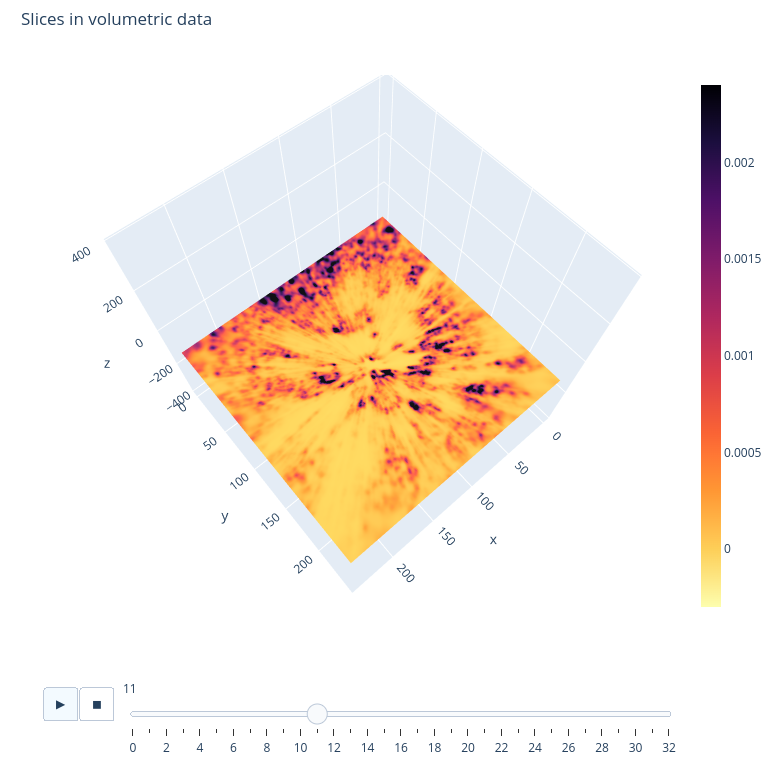

In [12]:
from IPython import display
display.Image("Volumetric_plot_example.png")